# Layer sizing

Resources:
* [Pytorch docs](https://pytorch.org/docs/stable/index.html)
* [C4W1L07 One Layer of a Convolutional Net, Deeplearning.ai](https://youtu.be/jPOAS7uCODQ)
* [PyTorch layer dimensions: what size and why?](https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd)

When you use Pytorch, if you don't use [Sequential](https://pytorch.org/cppdocs/api/classtorch_1_1nn_1_1_sequential.html#class-sequential) class you have to face the annoying problem of sizing layers "by hand". Sometimes it can be enough to let you scream and throw your laptop away. Keep calm, we can tackle it. It takes just a little bit of patience and practice.  
Here are few notes I took, about the specific steps to gradually go through the problem. These are not the "perfect method", so please if you have better to suggest do it, I'll be more than happy to be helped :); same for any typos/errors you'll find, so please let me know.

In [3]:
import torch, torch.nn

##### Data preparation

In [11]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms as T
root = '../_data/data_'
tsfm = T.Compose([
    T.ToTensor()
    ])
train = datasets.CIFAR10(root, train=True, download=True, transform=tsfm)
train_dl = DataLoader(train)


Files already downloaded and verified


### Tensor ranks convention

Pytorch makes some assumptions/conventions about tensor shapes in functions calls.  
Talking about tensor *ranks*, with respect to their position from left to right, in *Tensor.shape*, the single rank will be expected to be:  
1. batch size, N
2. number of features  
    2.1 Channels, C  
    2.2 Height, H  
    2.3 Width, W  
    
Follow some examples

In [13]:
"""Example tensor size outputs, how PyTorch reads them, and where you encounter them in the wild. 
Note: the values below are only examples. Focus on the rank of the tensor (how many dimensions it has)."""
print(torch.Size([32]))
    # 1d: [batch_size] 
    # use for target labels or predictions.
print(torch.Size([12, 256]))
    # 2d: [batch_size, num_features (aka: C * H * W)]
    # use for as nn.Linear() input.
print(torch.Size([10, 1, 2048]))
    # 3d: [batch_size, channels, num_features (aka: H * W)]
    # when used as nn.Conv1d() input.
    # (but [seq_len, batch_size, num_features]
    # if feeding an RNN).
print(torch.Size([16, 3, 28, 28]))
    # 4d: [batch_size, channels, height, width]
    # use for as nn.Conv2d() input.
print(torch.Size([32, 1, 5, 15, 15]))
    # 5D: [batch_size, channels, depth, height, width]
    # use for as nn.Conv3d() input.

torch.Size([32])
torch.Size([12, 256])
torch.Size([10, 1, 2048])
torch.Size([16, 3, 28, 28])
torch.Size([32, 1, 5, 15, 15])


Here an example about how know how many elements contains a "fully shaped" tensor

In [124]:
x = torch.rand((32, 1, 224, 224))

#                  4 ranks ---> 1 rank
print(f"shape: {x.shape}; contains {x.numel()} elements")

shape: torch.Size([32, 1, 224, 224]); contains 1605632 elements


##### <div id='helpers'>Helpers</div>

Here I define some helpers functions, in order to simplify later operations. You will recognize some formulas, they comes from Pytorch docs and are easily proved.

In [13]:
import numpy as np
#### Parameters calculation ####
conv_size  = lambda n, K, P, S: int(np.ceil((n -K + 2*P)/S +1))
conv_h_w   = lambda x, K,P,S: (conv_size(x.shape[2],K,P,S), conv_size(x.shape[3],K,P,S)) 
conv_K     = lambda n_in, n_out, P, S: int(np.ceil(( n_in +S*(1-n_out) + 2*P )))
conv_P     = lambda n_in, n_out, K, S: int(np.ceil((-n_in -S*(1-n_out) + K )/2))
conv_S     = lambda n_in, n_out, K, P: int(np.ceil(( n_in - K + 2*P)/(n_out-1)))
out_Conv2d = lambda x, C, N_out, K, P, S: list((x.shape[0], N_out, conv_h_w(x,K,P,S)[0], conv_h_w(x,K,P,S)[1]))
out_MaxPool2d = lambda x, C, K, P, S: list((x.shape[0], C, conv_h_w(x,K,P,S)[0], conv_h_w(x,K,P,S)[1]))

#out_Conv2d(x, C, N_out, K,P,S)

### Layers

Before to start sizing the network we have to know what we're dealing with in terms of variable and constrains, since it is all about managing a system.  It is worth to take a look to the most typical tranforming layers we'll encounter in our DL practice, and to see how they behave as code.

#### Linear
[```torch.nn.Linear(in_features, out_features, bias=True)```](https://pytorch.org/docs/master/generated/torch.nn.Linear.html#linear)

Linear always takes the **last dimension** of a Tensor as input features.

In [69]:
torch.nn.Linear?

In [91]:
x = torch.rand((128, 20));print(x.shape) ## 20 will be taken as input
N, n_in = x.shape
n_out = 60 # <- [C*H*W], play with this
print(f"n_in,n_out: {n_in, n_out}")
torch.nn.Linear(n_in, n_out)(x).shape

torch.Size([128, 20])
n_in,n_out: (20, 60)


torch.Size([128, 60])

In [92]:
x = torch.rand((128, 3, 20));print(x.shape)
N, C, n_in = x.shape
n_out = 64 # <- [H*W], play with this
print(f"n_in,n_out: {n_in, n_out}")
torch.nn.Linear(n_in, n_out)(x).shape

torch.Size([128, 3, 20])
n_in,n_out: (20, 64)


torch.Size([128, 3, 64])

In [110]:
x = torch.rand((32, 3, 224, 224));print(x.shape)
N, C, H, W = x.shape
n_in  = W # <- only choice
n_out = 8 # <- arbitrary
print(f"n_in,n_out: {n_in, n_out}")
torch.nn.Linear(n_in, n_out)(x).shape

torch.Size([32, 3, 224, 224])
n_in,n_out: (224, 8)


torch.Size([32, 3, 224, 8])

Now, we saw the Linear layer takes the last input size as features and "translate" it to a output size of features, what if we want to process **all** the units of our multirank tensor by it? This is, actually, the most common situation we'll run during our DL routines.  
In order to do so, we have to reshape our tensor into a linear shape, how? view is a perfect way.

In [98]:
torch.Tensor.view?

-1 acts as a placeholder in order to ask to Pytorch to replace it with a product result from all the missing dimensions.
CAVEAT: it doesn't mean the view performs a actual "product", it only reshapes the tensor from one shape of specific ranks sizes to another shape with a rank (the -1 one) having the **size** equal to the **product of the sizes** of the missing ranks in the function call.

In [104]:
print(x.shape)                  # 4 ranks
print(x.view(-1).shape)         # 1 rank: prod(rank0,rank1,rank2, rank3)
print(x.view(-1, 224).shape)    # 2 ranks: prod(rank0,rank1,rank2), rank3
print(x.view(-1, 224, 224).shape) # 3 ranks: prod(rank0,rank1), rank2, rank3
print(x.view(-1, 3, 224, 224).shape) # 4 ranks: prod(rank0), rank1, rank2, rank3

torch.Size([32, 3, 224, 224])
torch.Size([4816896])
torch.Size([21504, 224])
torch.Size([96, 224, 224])
torch.Size([32, 3, 224, 224])


Does it reminds about [tensor ranks convention](#Tensor-ranks-convention) seen before?

Now let's see how to take advantage of this in a typical Linear step

In [107]:
x = torch.rand((32, 3, 224, 224));print(x.shape)
N, C, H, W = x.shape
x2 = x.view(-1, C*H*W) # <-- here the trick!
n_in = x2.shape[1]
n_out = 8
print(f"n_in,n_out: {n_in, n_out}")
torch.nn.Linear(n_in, n_out)(x2).shape

torch.Size([32, 3, 224, 224])
n_in,n_out: (150528, 8)


torch.Size([32, 8])

#### Conv2d
[```torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')```](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html#conv2d)

Conv2d signature is very clear. About the output a simple formula has to be taken into account in order to compute a single free variable.  Below some examples about expected weight, $W_{out}$ and $H_{out}$.

In [4]:
x = torch.rand((32, 3, 224, 224));print(x.shape)
N, C, H, W = x.shape
K = 3 # kernel_size
C_out= 64
P = 1
S = 1
print(f"expected w: {(W -K  + 2*P)/S +1}")
print(f"expected h: {(H -K  + 2*P)/S +1}")
torch.nn.Conv2d(C, N_out, K, padding=P)(x).shape

torch.Size([32, 3, 224, 224])
expected w: 224.0
expected h: 224.0


torch.Size([32, 64, 224, 224])

In [5]:
x = torch.rand((32, 3, 224, 224));print(x.shape)
N, C, H, W = x.shape
K = 4
C_out= 64
P = 1   # <-- play with this
S = 1
print(f"expected w: {(W -K  + 2*P)/S +1}")
print(f"expected h: {(H -K  + 2*P)/S +1}")
torch.nn.Conv2d(C, N_out, K, padding=P, stride=S)(x).shape

torch.Size([32, 3, 224, 224])
expected w: 223.0
expected h: 223.0


torch.Size([32, 64, 223, 223])

This way we can compute the entire output shape. It will be, rank-by-rank:
1. the input batch size
2. the declared output channels (in the function call)
3. Calculated $H_{out}$ by formula
4. Calculated $W_{out}$ by formula

In [6]:
x = torch.rand((32, 3, 224, 224));print(x.shape)
N, C, H, W = x.shape
K = 4
C_out= 64
P = 1   # <-- play with this
S = 1
W_out = (W -K  + 2*P)/S +1
H_out = (H -K  + 2*P)/S +1
print(f"expected w: {W_out}")
print(f"expected h: {H_out}")
print(f"expected output: {[N, C_out, H_out, W_out]}")
torch.nn.Conv2d(C, N_out, K, padding=P, stride=S)(x).shape

torch.Size([32, 3, 224, 224])
expected w: 223.0
expected h: 223.0
expected output: [32, 64, 223.0, 223.0]


torch.Size([32, 64, 223, 223])

We can even use the helpers functions

In [14]:
x = torch.rand((32, 3, 224, 224));print(x.shape)
N, C, H, W = x.shape
K = 4
C_out= 64
P = 1   # <-- play with this
S = 1
print(f"expected output: {out_Conv2d(x, C, N_out, K, P, S)}")
torch.nn.Conv2d(C, N_out, K, padding=P, stride=S)(x).shape

torch.Size([32, 3, 224, 224])
expected output: [32, 64, 223, 223]


torch.Size([32, 64, 223, 223])

#### MaxPool2d
[```torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)```](https://pytorch.org/docs/master/generated/torch.nn.MaxPool2d.html#maxpool2d)

Basically it follows the same rule of Conv2d.

In [125]:
x = torch.rand((32, 3, 224, 224));print(x.shape)
N, C, H, W = x.shape
K = 6
P = 2   # <-- play with this
S = 1
print(f"expected w: {(W - K  + 2*P)/S +1}")
torch.nn.MaxPool2d(K, stride=S, padding=P)(x).shape

torch.Size([32, 3, 224, 224])
expected w: 223.0


torch.Size([32, 3, 223, 223])

In [19]:
### Maxpooling ###
x = torch.rand((32, 3, 224, 224));print(f"x: {x.shape}")
N, C, H, W = x.shape
K = 2
N_out= 64
P = 1   # <-- play with this
S = 2

print(f"Maxpool2D expected: {out_MaxPool2d(x, C, K, P ,S)}")
print( f"Maxpool2D: {torch.nn.MaxPool2d(K, stride=S, padding=P)(x).shape}" )
print(f"Conv2D expected: \t{out_Conv2d(x, C, N_out, K, P, S)}")
print(f"Conv2D expected: {torch.nn.Conv2d(C, N_out, K, padding=P, stride=S)(x).shape}")


x: torch.Size([32, 3, 224, 224])
Maxpool2D expected: [32, 3, 113, 113]
Maxpool2D: torch.Size([32, 3, 113, 113])
Conv2D expected: 	[32, 64, 113, 113]
Conv2D expected: torch.Size([32, 64, 113, 113])


#### Some playing

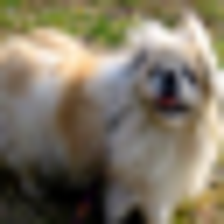

In [198]:
from torchvision.transforms import ToPILImage
from PIL import Image as pim
im = lambda t: ToPILImage()(t).convert("RGB")
imr  = lambda t: im(t).resize((224, 224)) # with auto-resize
item = lambda n: train[n][0]
imr(item(40))

In [172]:
a = train[40][0].unsqueeze(0)
a.shape

torch.Size([1, 3, 32, 32])

In [194]:
N, C, H, W = a.shape
K = 3 # kernel_size
N_out = 4
P = 1
S = 1
print(f"expected w: {(W -K  + 2*P)/S +1}")
aconv = torch.nn.Conv2d(C, N_out, K, padding=P)(a)
aconv.shape

expected w: 32.0


torch.Size([1, 4, 32, 32])

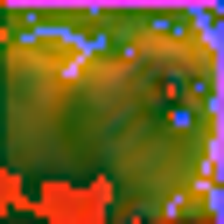

In [200]:
imr(aconv.squeeze(0))

### Sizing the network

Now that we have a picture on how to calculate dimensions during the data flow, we can setup our sketch of the network, playing with such dimensions, in order to make them work.  
Writing a proof we are free to put contrains, such like entering channels in a Conv2D layer and see how the tensors dimensions change along the layers.

In [307]:
#### Net ####
pool = torch.nn.MaxPool2d(2, 2)

print(f"x: {x.shape}") 
sz1 = pool(torch.nn.Conv2d(x.shape[1], 16, 3, padding=1, stride=1)(x)).shape
x2  = torch.rand(sz1); print(f"x2: {x2.shape}")
sz2 = pool(torch.nn.Conv2d(x2.shape[1], 32, 3, padding=1, stride=1)(x2)).shape
x3  = torch.rand(sz2); print(f"x3: {x3.shape}")
sz3 = pool(torch.nn.Conv2d(x3.shape[1], 64, 3, padding=1, stride=1)(x3)).shape
x4  = torch.rand(sz3); print(f"x4: {x4.shape}")
x5  = x4.view(-1, 28); print(f"x5: {x5.shape}")
sz4 = torch.nn.Linear(x5.shape[1], 500)(x5).shape
x6  = torch.rand(sz4); print(f"x6: {x6.shape}")
sz5 = torch.nn.Linear(x6.shape[1], 130)(x6).shape
x7  = torch.rand(sz5); print(f"x7: {x7.shape}")
print('here a FC will convert everything to one stripe')
x8  = x7.view(-1); print(f"x8: {x8.shape}")
sz6 = torch.nn.Linear(x8.shape[0], 132)(x8).shape
x9  = torch.rand(sz6); print(f"x9: {x9.shape}")



x: torch.Size([32, 3, 224, 224])
x2: torch.Size([32, 16, 112, 112])
x3: torch.Size([32, 32, 56, 56])
x4: torch.Size([32, 64, 28, 28])
x5: torch.Size([57344, 28])
x6: torch.Size([57344, 500])
x7: torch.Size([57344, 130])
here a FC will convert everything to one stripe
x8: torch.Size([7454720])
x9: torch.Size([132])


#### Alternative approach

Lazy bears (like me sometimes) can find a simpler try & error approach more easy to adopt, directly on the network. Let's see how.

##### First define your model

In [39]:
import torch.nn as nn
import torch.nn.functional as F

bs = 32 # batch size
nclasses = 20

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3, padding=1)
        self.conv2 = nn.Conv2d(4, 8, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8*56*56, 500)
        self.fc2 = nn.Linear(500, nclasses)
        self.dropout = nn.Dropout(0.25)
        self.v = True # verbose: print

    def forward(self, x):
        if self.v: print(f"1. x: {x.shape}")
        x = self.pool(F.relu(self.conv1(x)))
        if self.v: print(f"2. x: {x.shape}")
        x = self.pool(F.relu(self.conv2(x)))
        if self.v: print(f"3. x: {x.shape}")
        x = self.dropout(x)
        x = x.view(bs, -1)  # <- the previous trick
        if self.v: print(f"4. view: x: {x.shape}")
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        if self.v: print(f"5. view: x: {x.shape}")
        x = self.dropout(x)
        if self.v: print(f"6. x: {x.shape}")
        x = self.fc2(x)
        if self.v: print(f"7. x: {x.shape}")
        return x

###### Try it!

During your trials it's easy to run into some errors like the one below.  
```python
RuntimeError: size mismatch, m1: [32 x 25088], m2: [1024 x 500] at ..
```
Keep calm and just know that the first (m1) is referred to your travelling tensor, while m2 is referred to the dimensions you declared in your model. Just find your wrong dimensions in the model and edit them in order to match the expected ones as we saw in the previous sections.

In [41]:
## Let's check whether the model will let us do all the data flow ##
x = torch.rand((32, 3, 224, 224)) # batch of 32 RGB images 224x224
model = Net()
model(x).shape

1. x: torch.Size([32, 3, 224, 224])
2. x: torch.Size([32, 4, 112, 112])
3. x: torch.Size([32, 8, 56, 56])
4. view: x: torch.Size([32, 25088])
5. view: x: torch.Size([32, 500])
6. x: torch.Size([32, 500])
7. x: torch.Size([32, 20])


torch.Size([32, 20])

### Discussion

A couple of steps here deserve a little discussion

Here **4** is the linking dimension, from conv1 to conv2
```python
self.conv1 = nn.Conv2d(3, 4, 3, padding=1)
self.conv2 = nn.Conv2d(4, 8, 3, padding=1)
```  


Here **8** is the linking dimension, from conv2 to fc1  
```python
self.conv2 = nn.Conv2d(4, 8, 3, padding=1)
self.pool = nn.MaxPool2d(2, 2)
self.fc1 = nn.Linear(8*56*56, 500)
```  
You can notice the *Linear* input at *fc1*. It is because **8**, our linking dimension from previous layers, and 56x56, being the output H and W from *conv2*, as you can see in the model output steps.